In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import shutil

# Define the Generator model class
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(6)]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

# Residual Block class
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out
    
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_XtoY = Generator(in_channels=3, out_channels=3).to(device)
G_XtoY.load_state_dict(torch.load('/kaggle/input/monetgen/pytorch/monetgen_v1/1/G_XtoY.pth'))
G_XtoY.eval()

import os
from torchvision import transforms
from PIL import Image
import numpy as np

# Path to the directory containing photos
photos_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load and preprocess photos
photo_filenames = [f for f in os.listdir(photos_path) if f.endswith('.jpg')]
photos = []
for filename in photo_filenames:
    image = Image.open(os.path.join(photos_path, filename)).convert('RGB')
    image = transform(image)
    photos.append(image)

photos = torch.stack(photos)

# Directory to save the output images
output_dir = '/images'
os.makedirs(output_dir, exist_ok=True)

# Generate Monet-style images
with torch.no_grad():
    for i, photo in enumerate(photos):
        photo = photo.unsqueeze(0).to(device)  # Add batch dimension
        monet_style_image = G_XtoY(photo)
        monet_style_image = monet_style_image.squeeze(0).cpu()  # Remove batch dimension

        # Convert tensor to PIL Image and denormalize
        monet_style_image = transforms.ToPILImage()(monet_style_image * 0.5 + 0.5)
        monet_style_image.save(os.path.join(output_dir, f'monet_style_{i+1}.jpg'))


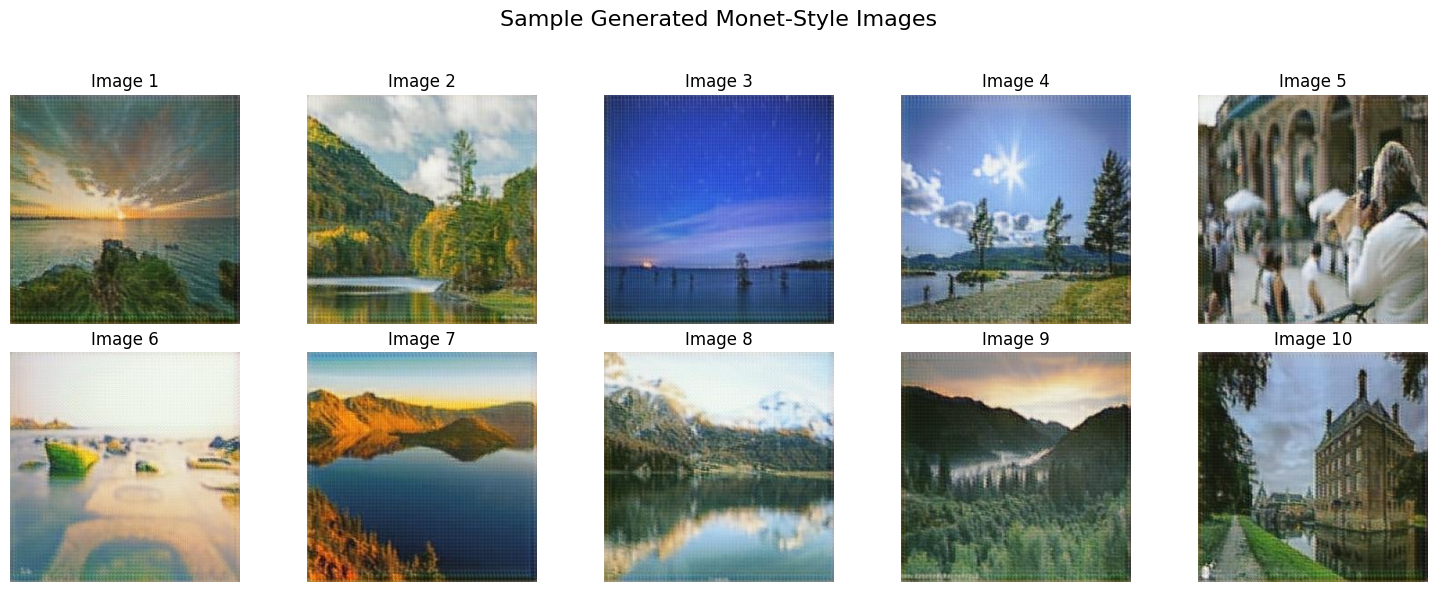

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing generated images
output_dir = '/images'

# Number of images to display
num_images = 10

# Get list of image file names
image_files = [f for f in os.listdir(output_dir) if f.endswith('.jpg')]

# Randomly select images to display
sample_images = random.sample(image_files, num_images)

# Set up Matplotlib figure
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Generated Monet-Style Images', fontsize=16)

# Plot images
for i, ax in enumerate(axs.flatten()):
    img_path = os.path.join(output_dir, sample_images[i])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Turn off axis
    ax.set_title(f"Image {i+1}")

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Evaluating your generated images using the same metrics as the competition can give you valuable insights into the quality and diversity of your images before submitting them. Let’s focus on building and testing the MiFID metric locally, along with some foundational steps to calculate FID and ensure the generated images are not memorized replicas of the training set.

### Step-by-Step Guide to Building and Testing Evaluation Metrics

We'll cover:

1. **Downloading and Setting Up Inception Model**: The Inception v3 model will be used to extract features for both real and generated images.
2. **Calculating FID**: Implementing the Fréchet Inception Distance.
3. **Calculating Memorization Distance**: Ensuring generated images are not just memorized versions of training images.
4. **Combining for MiFID**: Incorporating both FID and the memorization distance for the MiFID metric.

#### Step 1: Setting Up Inception Model

You’ll need the Inception v3 model for feature extraction. Let's install the necessary libraries and load the model.

```python
!pip install torch torchvision numpy scipy
```

In [15]:
import torch
from torchvision.models import inception_v3
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import os
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import cosine_similarity

# Load Inception v3 model
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.eval()  # Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inception_model = inception_model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Step 2: Defining Datasets

Define datasets for real Monet images and the generated images for evaluation. You’ll also need a dataset for photos if you want to check for memorization against the photo dataset.

In [16]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Image transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 expects 299x299 input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [33]:
# Paths to datasets
real_images_path = "/kaggle/input/gan-getting-started/monet_jpg"
generated_images_path = "/images"

# Create datasets
real_dataset = ImageDataset(real_images_path, transform=transform)
generated_dataset = ImageDataset(generated_images_path, transform=transform)

# DataLoaders for batch processing
batch_size = 32
real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
generated_loader = DataLoader(generated_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


#### Step 3: Extracting Features Using Inception v3

To calculate FID and memorization distance, extract features from the Inception v3 model.

In [34]:
# Function to extract features using InceptionV3
def get_inception_features(data_loader, device):
    model = inception_v3(pretrained=True, transform_input=False)
    model.fc = torch.nn.Identity()  # Remove the final classification layer
    model.eval()
    model.to(device)

    features = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            feat = model(batch)
            features.append(feat.cpu().numpy())

    features = np.concatenate(features, axis=0)
    return features

In [36]:
# Extract features
real_features = get_inception_features(real_loader, device)
print(real_features.shape)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(300, 2048)


In [37]:
# Extract features
generated_features = get_inception_features(generated_loader, device)
print(generated_features.shape)

(7038, 2048)


#### Step 4: Calculating FID

Calculate the Fréchet Inception Distance (FID) between the real and generated images.

In [38]:
def calculate_fid(real_features, generated_features):
    mu_real = np.mean(real_features, axis=0)
    mu_generated = np.mean(generated_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_generated = np.cov(generated_features, rowvar=False)
    
    diff = mu_real - mu_generated
    covmean, _ = sqrtm(sigma_real.dot(sigma_generated), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_generated - 2 * covmean)
    return fid

In [55]:
fid = calculate_fid(real_features, generated_features)
print("FID:", fid)

FID: 8.062834757772801e+81


#### Step 5: Calculating Memorization Distance

Compute the memorization distance between the generated images and real Monet images.

In [30]:
def calculate_memorization_distance(real_features, generated_features):
    distances = cosine_similarity(generated_features, real_features)
    min_distances = 1 - np.max(distances, axis=1)
    memorization_distance = np.mean(min_distances)
    return memorization_distance

memorization_distance = calculate_memorization_distance(real_features, generated_features)
print("Memorization Distance:", memorization_distance)


Memorization Distance: 3.1789145e-09


#### Step 6: Calculating MiFID

Combine FID and memorization distance to get MiFID.

In [31]:
def calculate_mifid(fid, memorization_distance, threshold=0.1):
    weight = 1 if memorization_distance < threshold else 1 / memorization_distance
    mifid = fid * weight
    return mifid

mifid = calculate_mifid(fid, memorization_distance)
print("MiFID:", mifid)


MiFID: 2.535301200456459e+30
